05 自動特徴量選択
==============

* 新しい特徴量を作る方法が多くあるので、データの次元数を元の特徴量の数よりもはるかに大きくしたくなることもある

    * しかし、特徴量を追加すると、モデルは複雑になり、過剰適合の可能性が高くなる
    
    * 新しい特徴量を加える場合、また高次元データセット一般の場合、最も有用な特徴量だけを残して残りを捨てて、特徴量の数を減らすのは良い考えである
    
    * こうすることで、モデルが単純になり、汎化性能が向上する
    
    * 良い特徴量がわかる3つの戦略があり、`単変量統計`、`モデルベース選択`、`反復選択`の3つ
    
    * これらの手法は全て教師あり学習なので、モデルを適合するためのターゲットが必要である
    
    * 従って、データを訓練セットとテストセットに分割し、特徴量選択は、訓練セットだけを用いて行うようにしなければならない

## 1. 単変量統計

* `単変量統計`：個々の特徴量とターゲットとの間に、統計的に顕著な関係があるかどうかを計算する

    * 最も高い確信度で関連している特徴量が選択される
    
    * クラス分類の場合は、`分散分析`(ANOVA)として知られる
    
    * この方法の特性は`単変量`であり、個々の特徴量を個別に考慮する
    
    * 従って、他の特徴量と組み合わせて意味を持つような特徴量は捨てられてしまう
    
    * 単変量テストは計算が高速で、モデルを構築する必要がない
    
    * 一方で、特徴量選択時に利用するモデルと完全に独立である

* 単変量特徴量選択をscikit-learnで使うには、テストを選択する必要がある

    * 通常、クラス分類には`f_classif`(デフォルト値)を、回帰には`f_regression`を用いる
    
    * さらに、テストで求められる`p-値`を元に、特徴量を捨てる方法も指定する
    
    * これらの方法には、`p-値`が大きすぎる(ターベットとの関係が低い)特徴量を捨てる際の`スレッショルド`を指定する
    
* `スレッショルド`の計算方法は手法によって異なる

    * 最も単純な`SelectKBest`では、選択する特徴量の数を指定する
    
    * `SelectPercentile`は残す特徴量の割合を選択する
    
* cancerデータセットのクラス分類に特徴量抽出を適用してみる
    
    * 少しタスクを難しくするために、情報量のないノイズを加える
    
    * 特徴量検出がこの情報量のない特徴量を検出して取り除いてくれることを期待する

In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# シードを指定して乱数を設定
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# ノイズ特徴量をデータに加える
# 最初の30特徴量はデータセットからきたもの。続く50特徴量はノイズ
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# f_classif(デフォルト)とSelectPercentileを使って50%の特徴量を選択
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# 訓練セットを変換
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


* 特徴量の数が80から40に減っている(元の特徴量の50%)

* どの特徴量が使われているかを`get_support`メソッドで調べることができる

    * このメソッドは選択された特徴量を示す真偽値のマスクを返す

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([], <a list of 0 Text yticklabel objects>)

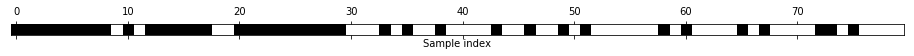

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
mask = select.get_support()
print(mask)
# マスクを可視化する。黒が真、白が偽
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

* 可視化したマスクでわかるように、元の特徴量のほとんどが選択されており、ほとんどのノイズ特徴量が取り除かれている

    * しかし、元の特徴量の回復は完全ではない
    
* ロジスティック回帰の性能を、全ての特徴量を使った場合と、選択された特徴量だけを使った場合で比較する

In [5]:
from sklearn.linear_model import LogisticRegression

# テストデータの変換
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


* この場合、ノイズ特徴量を取り除くと、元の特徴量のいくつかが失われているにも関わらず、性能が向上している

    * これは単純な合成したサンプルの結果で、実際のデータに適応すると性能が向上するとは限らない
    
    * それでも、特徴量が多すぎてモデルを作れない場合や、多くの特徴量が全く関係ないと思われる場合には、単変量特徴量選択は有用

## 2. モデルベース特徴量選択

* `モデルベース特徴量選択`は、教師あり学習モデルを用いて個々の特徴量の重要性を判断し、重要なものだけを残す手法である

    * 特徴量選択に用いる教師あり学習モデルは、最終的に使う教師あり学習モデルと同じでなくても良い
    
    * 特徴量選択に用いるモデルは、選択時に特徴量に順番を付けるために、個々の特徴量の重要性の指標を出力するものでなければならない
    
    * 決定木や決定木ベースのモデルには、特徴量の重要性そのものをエンコードした`feature_importances_`属性がある
    
    * 線形モデルには係数があり、これも絶対値をとれば、特徴量の重要性を捉えた値として利用できる
    
    * 例)`L1ペナルティ`を用いた線形モデルは、疎な係数を学習し、特徴量のごく一部しか利用しないようになる
    
        * これは、モデルによる特徴量選択としても考えることもできる
        
        * これを前処理過程として使って、別のモデルで使う特徴量選択を行うこともできる

* `単変量選択`の場合と対象的に、`モデルベース`の選択は、全ての特徴量を同時に考慮するので、変数間の交互作用を捉えることができる

    * ただし、選択に使うモデルが交互作用を捉えることができる場合
    
* モデルベース特徴量選択を用いるには、`SelectFromModel`変換器を用いれば良い

In [6]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

* `SelectFromModel`クラスは教師あり学習モデルで得られた特徴量の重要性が、指定したスレッショルドよりも大きい特徴量だけを選択する

    * 単変量特徴量選択での結果と比較するために、中央値をスレッショルドとして半分の特徴量が選ばれるようにする
    
    * 100決定木を用いるランダムフォレストを使って、特徴量の重要性を計算する
    
    * これは非常に複雑なモデルなので、単変量テストを用いるよりもはるかに強力な手法である
    

In [7]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


* 選択された特徴量を見てみる

([], <a list of 0 Text yticklabel objects>)

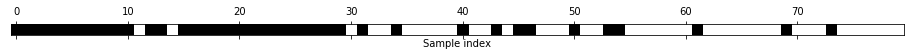

In [8]:
mask = select.get_support()
# マスクを可視化する。黒が真、白が偽
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

* 今度は、元の特徴量は2つを除いて選択されている

* 40特徴量を選択しているので、ノイズ特徴量もいくつか選択されている

In [9]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


* 良い特徴量を選択することで、性能も向上している

## 3. 反復特徴量選択

* `単変量テスト`ではモデルを全く使わず、`モデルベース選択`では1つだけ使って、特徴量を選択した

* `反復特徴量選択`(RFE)：異なる特徴量を用いた一連のモデルを作る

    * これには2つの基本的な方法がある
    
    1. 全く特徴量を使わないところから、ある基準が満たされるところまで1つずつ特徴量を加えていく方法
    
    1. すべての特徴量を使う状態から1つずつ特徴量を取り除いていく方法
    
    * 多数のモデルを作るため、上で述べた方法よりも計算的にはるかに高価な手法となる
    
* この方法の1つが、`再帰的特徴量削減`である

    * この方法は、すべての特徴量から開始してモデルを作る、最も重要度が低い特徴量を削除する
    
    * この過程を事前に定めた数の特徴量になるまで繰り返す
    
    * これが機能するためには、`モデルベース選択`の場合と同様に、選択に用いるモデルが特徴量の重要性を決定する方法を提供していなければならない
    
* ここでは、先に用いたのと同じランダムフォレストモデルを用いる

([], <a list of 0 Text yticklabel objects>)

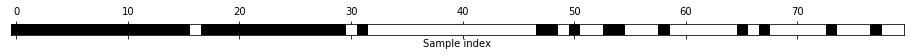

In [10]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# 選択された特徴量を可視化する
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

* 単変量やモデルベース選択の場合と比較して特徴量の選択は良くなっているが、それでも元の特徴量のうち1つがなくなっている

    * また、この方法はモデルベース選択の場合と比べてもはるかに時間がかかる
    
    * 1つずつ特徴量を落としていくために、ランダムフォレストを40回も学習しているため
    
* `RFE`を用いて選択した特徴量を用いたロジスティック回帰モデルの精度を見てみる    

In [11]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


/Users/MacUser/anaconda2/envs/tf140/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


* `RFE`の内部で用いられたモデルを用いて予測を行うこともできる

    * これは選択された特徴量だけを用いる

In [12]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


* `RFE`内部で用いられたランダムフォレストの性能は、選択された特徴量で訓練したロジスティック回帰モデルと同じ

    * つまり、適切な特徴量を選んだことで、線形モデルの性能がランダムフォレストと同じになったということになる

* 機械学習アルゴリズムに対してどの特徴量を入力として使ったら良いかわからない場合には、自動特徴量選択は有用である

    * また、例えば、予測を高速化したい場合や、解釈しやすいモデルを構築したい場合などに、必要な特徴量の量を減らすためにも役に立つ
    
    * 実世界のデータでは、特徴量選択で性能が大幅に向上することはあまりない
    
    * しかし、特徴量エンジニアがツールボックスに備えておくべきツールであることに変わりはない

|  版  |   年/月/日   |
|-----|-----------------|
|初版|2019/03/21|